In [2]:
for name in dir():
 if not name.startswith("_"):
   del globals()[name]

#Import necessary packages
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
import pickle

from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from scipy import interp
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from joblib import Parallel, delayed

In [2]:
df_sample = pd.read_csv("data/sample_submission.csv", header="infer")
print(df_sample.shape)
print(df_sample.head())
print(df_sample.tail())

(506691, 2)
   TransactionID  isFraud
0        3663549      0.5
1        3663550      0.5
2        3663551      0.5
3        3663552      0.5
4        3663553      0.5
        TransactionID  isFraud
506686        4170235      0.5
506687        4170236      0.5
506688        4170237      0.5
506689        4170238      0.5
506690        4170239      0.5


In [108]:
random_probs = np.random.uniform(0, 1, 506691)
df_random = df_sample.copy()
df_random['isFraud'] = random_probs

In [109]:
print(df_random.shape)
print(df_random.head())
print(df_random.tail())

(506691, 2)
   TransactionID   isFraud
0        3663549  0.777565
1        3663550  0.330396
2        3663551  0.409880
3        3663552  0.620834
4        3663553  0.159737
        TransactionID   isFraud
506686        4170235  0.583579
506687        4170236  0.593995
506688        4170237  0.623146
506689        4170238  0.638177
506690        4170239  0.451321


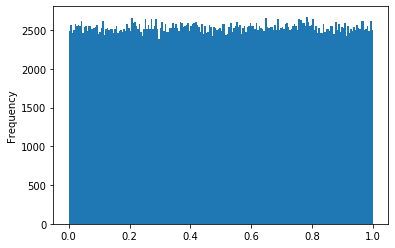

In [110]:
df_random['isFraud'].plot(kind='hist', bins=200)

In [46]:
df_random.to_csv('data/random_out.csv', header=True, index=False)

In [3]:
df_identity_train = pd.read_csv("data/train_identity.csv", header="infer")
df_identity_test = pd.read_csv("data/test_identity.csv", header="infer")

In [4]:
df_transaction_train = pd.read_csv("data/train_transaction.csv", header="infer")
df_transaction_test = pd.read_csv("data/test_transaction.csv", header="infer")

In [5]:
print(df_identity_train.shape)
print(df_transaction_train.shape)

print(df_identity_test.shape)
print(df_transaction_test.shape)

(144233, 41)
(590540, 394)
(141907, 41)
(506691, 393)


In [6]:
df_identity_train.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
df_transaction_train.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0

In [6]:
df_transaction_train['TransactionDT'] = df_transaction_train['TransactionDT'] - 86400

In [7]:
df_transaction_train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [8]:
df_transaction_train['TransactionID'].nunique()

590540

In [11]:
def check_missing(df):
    df_missing = pd.concat([df.nunique(), df.isnull().any(), df.isnull().sum()], axis=1)
    df_missing.columns = ['nunique', 'isnull_any', 'isnull_count']
    df_missing['missing'] = df_missing['isnull_count'] / float(len(df))
    return (df_missing)

In [9]:
%%time
if 0:
    df0 = df_transaction_train[ df_transaction_train['isFraud'] == 0 ]
    df0_missing = check_missing(df0)

    df1 = df_transaction_train[ df_transaction_train['isFraud'] == 1 ]
    df1_missing = check_missing(df1)
    df_missing = pd.merge(df0_missing, df1_missing, how="left", left_index=True, right_index=True)
    df_missing.to_pickle('./data/pickles/approach1/df_missing.pkl')
else:
    df_missing = pd.read_pickle('./data/pickles/approach1/df_missing.pkl')

In [10]:
df_missing

,nunique_x,isnull_any_x,isnull_count_x,missing_x,nunique_y,isnull_any_y,isnull_count_y,missing_y
TransactionID,569877,False,0,0.000000,20663,False,0,0.000000
isFraud,1,False,0,0.000000,1,False,0,0.000000
TransactionDT,553717,False,0,0.000000,20638,False,0,0.000000
TransactionAmt,20560,False,0,0.000000,2515,False,0,0.000000
ProductCD,5,False,0,0.000000,5,False,0,0.000000
card1,13350,False,0,0.000000,1740,False,0,0.000000
card2,500,True,8510,0.014933,327,True,423,0.020471
card3,106,True,1526,0.002678,62,True,39,0.001887
card4,4,True,1536,0.002695,4,True,41,0.001984
card5,118,True,4049,0.007105,49,True,210,0.010163


In [15]:
column = 'M1'
column = 'card1'

print(df_transaction_train[df_transaction_train['isFraud'] == 0][column].value_counts())
print(df_transaction_train[df_transaction_train['isFraud'] == 1][column].value_counts())

7919     14820
9500     13634
17188    10066
15885     9917
15066     7632
12695     6890
12544     6627
6019      6477
2803      6068
7585      5071
12839     5059
10616     4970
3154      4328
18132     4150
2616      4096
15497     3934
16132     3865
2884      3821
11207     3650
16075     3566
10112     3525
9633      3416
7508      3394
12501     3084
10057     3044
7826      2929
16659     2920
12577     2864
7861      2718
6530      2706
7664      2665
8320      2610
7207      2510
5812      2504
5033      2503
4461      2487
10023     2385
7815      2370
10486     2364
9112      2329
15063     2203
16560     2073
4806      2043
7676      2025
16136     1998
12932     1934
4436      1930
1444      1925
17399     1894
11839     1884
13832     1866
2772      1864
14290     1729
1675      1723
2455      1710
11157     1696
9026      1679
17055     1652
3821      1635
1974      1584
1893      1576
17131     1570
18018     1554
1724      1516
8528      1499
2392      1490
15775     

In [15]:
df_transaction_train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.00

In [16]:
df = df_transaction_train[['TransactionID', 'TransactionDT', 'V141']]
df.head()
df.tail()

,TransactionID,TransactionDT,V141
590535,3577535,15724647,NaN
590536,3577536,15724649,NaN
590537,3577537,15724679,NaN
590538,3577538,15724688,NaN
590539,3577539,15724731,NaN


In [17]:
df['dt2'] = 0
df.loc[0:(len(df)-2), 'dt2'] = df['TransactionDT'][1:].values
df['diff'] = df['dt2'] - df['TransactionDT']
df[ df['diff'] < 0]

,TransactionID,TransactionDT,V141,dt2,diff
590539,3577539,15724731,NaN,0,-15724731


In [18]:
df.head()

,TransactionID,TransactionDT,V141,dt2,diff
0,2987000,0,NaN,1,1
1,2987001,1,NaN,69,68
2,2987002,69,NaN,99,30
3,2987003,99,NaN,106,7
4,2987004,106,0.0,110,4


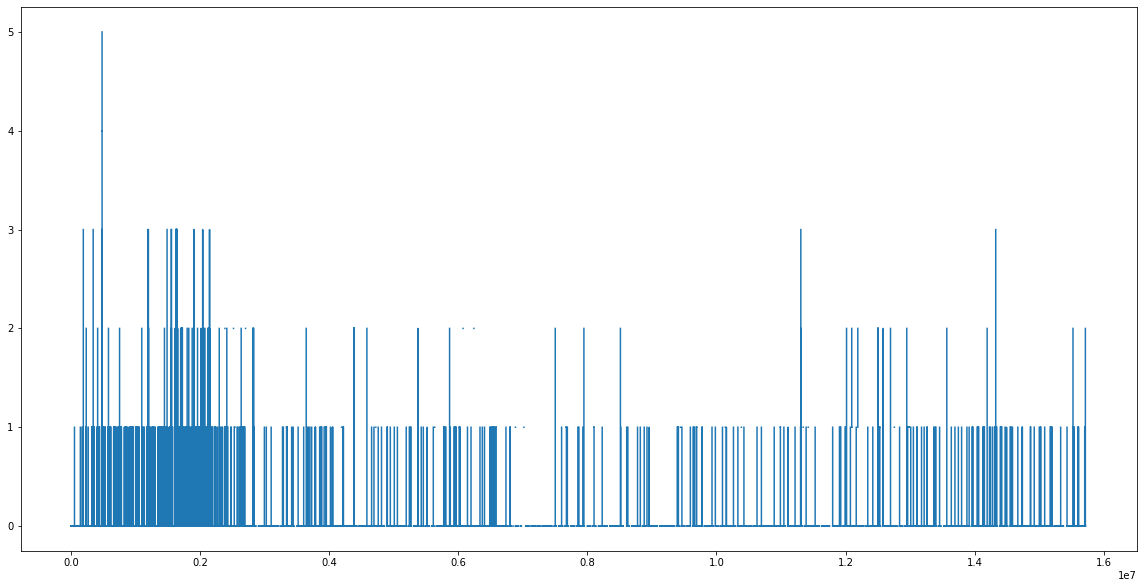

In [19]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()
ax.plot(df['TransactionDT'], df['V141'], linestyle='-')
plt.show()

In [20]:
column = 'V141'
s0 = df_transaction_train[ df_transaction_train['isFraud'] == 0 ][column]
s1 = df_transaction_train[ df_transaction_train['isFraud'] == 1 ][column]

print(ks_2samp(s0, s1))

Ks_2sampResult(statistic=0.03926196610525068, pvalue=4.00619209743477e-27)


In [21]:
print(s0.value_counts())

print(s0.isnull().sum())

a0 = s0[ ~s0.isna() ]
a1 = s1[ ~s1.isna() ]

print(ks_2samp(a0, a1))

0.0    75921
1.0     2144
2.0      200
3.0       26
5.0        2
4.0        2
Name: V141, dtype: int64
491582
Ks_2sampResult(statistic=0.06830891596324762, pvalue=1.46809891623235e-14)


In [11]:
#-------------------------------------------------------------------------------
# Computes the statistical distance between two samples using the KS-test.
# This is used to determine if the distribution of the attribute columns are
# statistically different when failure = 0 and failure = 1.
#-------------------------------------------------------------------------------

#from scipy.stats.mstats import ks_2samp as ks_2sampm

def compute_statistical_distance(df, feature):
    s0 = df[ df['isFraud'] == 0 ][feature]
    s1 = df[ df['isFraud'] == 1 ][feature]
    
    a0 = s0[ ~s0.isna() ]
    a1 = s1[ ~s1.isna() ]
    compare = ks_2samp(a0, a1)
    
    return ([feature, compare.statistic, compare.pvalue])

In [12]:
all_columns = df_transaction_train.columns.tolist()

In [13]:
all_cat_features = [
                'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
                'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9' 
              ]

excl_columns = all_cat_features + ['TransactionID', 'isFraud', 'TransactionDT']

all_num_features = [col for col in all_columns if col not in excl_columns]

In [14]:
print(len(excl_columns))
print(len(all_cat_features))
print(len(all_num_features))

23
20
371


In [15]:
%%time
if 0:
    compare_lists = Parallel(n_jobs=20)(
                    delayed(compute_statistical_distance)(df_transaction_train, col) 
                    for col in all_num_features
                )
    df_compare = pd.DataFrame.from_records(compare_lists, columns=['feature', 'statistic', 'pvalue'])
    df_compare.to_pickle('./data/pickles/approach1/df_kstest_comparison.pkl')
else:
    df_compare = pd.read_pickle('./data/pickles/approach1/df_kstest_comparison.pkl')

In [16]:
df_compare.head()

,feature,statistic,pvalue
0,TransactionAmt,0.075649,1.533201e-99
1,dist1,0.109743,3.564254e-49
2,dist2,0.073436,3.607917e-16
3,C1,0.187575,0.000000e+00
4,C2,0.204344,0.000000e+00


In [17]:
# 1. Remove numerical features based on KS significance test
removed_features_kstest = df_compare[ df_compare['pvalue'] > 0.01 ]['feature'].tolist()
numeric_features = sorted(df_compare[ df_compare['pvalue'] <= 0.01 ].sort_values(by='pvalue', ascending=False)['feature'].tolist())
print(len(removed_features_kstest))
print(len(numeric_features))

35
336


In [18]:
df_numeric = df_transaction_train[numeric_features].copy()

In [19]:
df_numeric.head()

,C1,C10,C11,C12,C13,C14,C2,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,TransactionAmt,V10,V100,V101,V102,V103,V104,V105,V106,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V15,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V16,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V17,V170,V171,V174,V175,V176,V177,V178,V179,V18,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V2,V20,V200,V201,V202,V203,V204,V208,V209,V21,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V22,V220,V221,V222,V224,V225,V226,V227,V228,V229,V23,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V24,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V26,V260,V261,V262,V263,V264,V265,V267,V268,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V306,V307,V308,V309,V31,V310,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V322,V323,V324,V326,V327,V328,V329,V33,V330,V331,V332,V333,V335,V336,V337,V338,V339,V34,V35,V36,V37,V38,V39,V4,V40,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V66,V67,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,dist1,dist2
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,13.0,13.0,NaN,NaN,NaN,0.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,68.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,1.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,19.0,NaN
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,29.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.

In [20]:
%%time
if 0:
    corr_matrix = df_numeric.corr()
    corr_matrix.to_pickle('./data/pickles/approach1/corr_matrix.pkl')
else:
    corr_matrix = pd.read_pickle('./data/pickles/approach1/corr_matrix.pkl')

In [21]:
corr_matrix.shape

(336, 336)

In [24]:
def collinearity_data_frame(upper, to_drop, threshold=0.95):
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

    # Iterate through the columns to drop
    for column in to_drop:
        # Find the correlated features
        corr_features = list(upper.index[upper[column].abs() > threshold])

        # Find the correlated values
        corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
        drop_features = [column for _ in range(len(corr_features))]    

        # Record the information (need a temp df for now)
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

        # Add to dataframe
        record_collinear = record_collinear.append(temp_df, ignore_index = True)
        
    return(record_collinear)

In [22]:
correlation_threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

In [23]:
len(to_drop)

131

In [25]:
record_collinear = collinearity_data_frame(upper, to_drop)
record_collinear['drop_feature'].value_counts()
record_collinear.head()

,drop_feature,corr_feature,corr_value
0,C10,C1,0.958202
1,C11,C1,0.996515
2,C11,C10,0.956056
3,C12,C10,0.983817
4,C14,C1,0.951761


In [26]:
import seaborn as sns

def plot_collinear(corr_matrix, record_collinear):
    """
    Heatmap of the features with correlations above the correlated threshold in the data.

    Notes
    --------
    - Not all of the plotted correlations are above the threshold because this plots
      all the variables that have been idenfitied as having even one correlation above the threshold
    - The features on the x-axis are those that will be removed. The features on the y-axis
      are the correlated feature with those on the x-axis

    """

    if record_collinear is None:
        raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')

    # Identify the correlations that were above the threshold
    corr_matrix_plot = corr_matrix.loc[list(set(record_collinear['corr_feature'])), 
                                                    list(set(record_collinear['drop_feature']))]

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                        linewidths=.25, cbar_kws={"shrink": 0.6})

    ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
    ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

    ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
    ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));

    plt.xlabel('Features to Remove', size = 8); plt.ylabel('Correlated Feature', size = 8)
    plt.title("Correlations Above Threshold", size = 14)

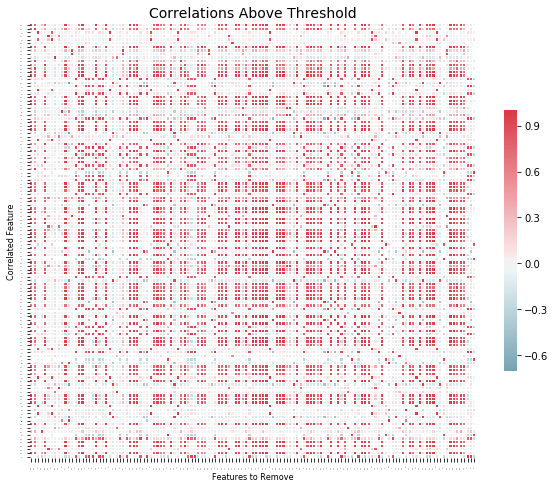

In [31]:
plot_collinear(corr_matrix, record_collinear)

In [27]:
# 2. Remove numerical features based on collinearity
removed_features_collinear = to_drop
numeric_features = [col for col in numeric_features if col not in removed_features_collinear]
print(len(to_drop))
print(len(numeric_features))

131
205


In [68]:
# 3. Remove features with large number of missing data values
max_missing_percent = 0.7
missing_features_all = df_missing[ df_missing['missing_x'] > max_missing_percent ].index.tolist()
print(len(missing_features_all))

numeric_features = [col for col in numeric_features if col not in missing_features_all]
print(len(numeric_features))

cat_features = [col for col in all_cat_features if col not in missing_features_all]
print(len(cat_features))

168
115
19


In [82]:
cat_features

['ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'P_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [83]:
def categorical_correlation(df, f1, f2, threshold=0.95):
    df_tmp = df[['TransactionID', f1, f2]].copy()
    dfc = df_tmp.groupby([f1, f2]).count().reset_index()
    dfcp = dfc.pivot(index=f1, columns=f2, values='TransactionID').fillna(0)
    corr = 0
    if len(dfcp) > 0:
        table = dfcp.values.tolist()

        stat, p, dof, expected = chi2_contingency(table)

        # interpret test-statistic
        #critical = chi2.ppf(threshold, dof)
        alpha = 1.0 - threshold
        corr = 1 - p

        #if p <= alpha:
        #    print('Dependent (reject H0)')
        #else:
        #    print('Independent (fail to reject H0)')
    
    return (corr)

In [84]:
m = len(cat_features)
print(m)
corr_matrix2 = pd.DataFrame(np.zeros((m, m)), index=cat_features, columns=cat_features)

19


In [85]:
for i in range(m):
    f1 = cat_features[i]
    for j in range(i+1, m):
        f2 = cat_features[j]
        corr_matrix2.loc[f1, f2] = categorical_correlation(df_transaction_train, f1, f2)

In [86]:
#corr_matrix2.loc[f1, f2] = 0
corr_matrix2.shape

(19, 19)

In [89]:
correlation_threshold = 0.95
upper = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]
len(to_drop)

18

In [94]:
record_collinear = collinearity_data_frame(upper, to_drop)
#record_collinear['drop_feature'].value_counts()
record_collinear.sort_values('corr_value', ascending=True)

,drop_feature,corr_feature,corr_value
116,M7,M5,0.988470
99,M6,addr2,0.989910
121,M8,card4,0.997182
87,M5,addr2,0.998737
140,M9,M1,0.999192
143,M9,M4,0.999447
78,M4,M2,0.999516
61,M3,card4,0.999890
123,M8,card6,0.999914
107,M7,card3,0.999971


In [96]:
# 4. Remove categorical features based on collinearity
removed_features_collinear = to_drop
cat_features = [col for col in cat_features if col not in removed_features_collinear]
print(len(to_drop))
print(cat_features)

18
['ProductCD']


In [102]:
# imputation methods

def impute_missing_numeric(df, replace):
    for col in df.columns.tolist():
        df[col].fillna(replace[col], inplace=True)
        
def impute_missing_categorical(df):
    for col in df.columns.tolist():
        #df[col].fillna('NA', inplace=True)
        df[col] = df[col].map(lambda x: str(x).rstrip('.0'))

In [149]:
def prepare_training_data(df_transaction_train, numeric_features, cat_features):
    df_numeric_train = df_transaction_train[numeric_features].copy()
    df_categorical_train = df_transaction_train[cat_features].copy()
    
    # replacement strategy
    replace_num = np.mean(df_numeric_train)
    
    # imputation of missing fature values
    # imputing numeric features
    impute_missing_numeric(df_numeric_train, replace_num)
    
    # imputing categorical features
    #impute_missing_categorical(df_categorical_train)
    
    encoding_cat = OneHotEncoder()
    encoding_cat.fit(df_categorical_train)
    df_categorical_train_enc = pd.DataFrame(
        encoding_cat.transform(df_categorical_train).toarray(), columns=encoding_cat.get_feature_names()
    )
    
    df_train = df_transaction_train[['TransactionID', 'isFraud']].copy()
    df_train = pd.merge(df_train, df_categorical_train_enc, how='left', left_index=True, right_index=True)
    df_train = pd.merge(df_train, df_numeric_train, how='left', left_index=True, right_index=True)
    
    return (df_train, replace_num, encoding_cat)

In [150]:
def prepare_testing_data(
        df_transaction_test, numeric_features, cat_features, replace_num, encoding_cat
):
    df_numeric_test = df_transaction_test[numeric_features].copy()
    df_categorical_test = df_transaction_test[cat_features].copy()
    
    # imputation of missing values
    # numeric features
    impute_missing_numeric(df_numeric_test, replace_num)
    
    # imputing categorical features
    #impute_missing_categorical(df_categorical_test)
    df_categorical_test_enc = pd.DataFrame(
        encoding_cat.transform(df_categorical_test).toarray(), columns=encoding_cat.get_feature_names()
    )
    
    df_test = df_transaction_test[['TransactionID']].copy()
    df_test = pd.merge(df_test, df_categorical_test_enc, how='left', left_index=True, right_index=True)
    df_test = pd.merge(df_test, df_numeric_test, how='left', left_index=True, right_index=True)
    
    return (df_test)

In [152]:
%%time
if 0:
    df_train, replace_num, encoding_cat = prepare_training_data(df_transaction_train, numeric_features, cat_features)
    df_train.to_pickle('./data/pickles/approach1/df_train.pkl')
else:
    df_train = pd.read_pickle('./data/pickles/approach1/df_train.pkl')

In [153]:
print(df_train.shape)
df_train.head()

(590540, 122)


,TransactionID,isFraud,x0_C,x0_H,x0_R,x0_S,x0_W,C1,C13,C5,C9,D1,D10,D11,D15,D3,D5,TransactionAmt,V10,V100,V101,V102,V104,V105,V108,V109,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V129,V13,V130,V131,V135,V136,V137,V15,V17,V19,V2,V20,V23,V24,V26,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V297,V3,V300,V301,V302,V303,V309,V31,V310,V312,V313,V314,V315,V319,V320,V321,V35,V36,V37,V38,V39,V4,V40,V42,V44,V45,V46,V47,V48,V5,V51,V53,V54,V55,V56,V59,V61,V62,V64,V66,V67,V69,V7,V73,V75,V76,V77,V78,V79,V80,V82,V83,V85,V86,V87,V9,V90,V98,dist1
0,2987000,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,14.0,13.000000,13.000000,0.000000,13.000000,42.335965,68.5,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542594,0.579198,1.108065,1.1624,0.166076,1.000000,0.177145,0.156118,1.083891,1.120779,1.022286,1.038515,0.383174,1.000000,0.170579,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0000,1.00000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.0,19.00000
1,2987001,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,146.621465,0.000000,28.343348,42.335965,29.0,0.463915,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,1.000000,1.045204,1.000000,1.000000,1.000000,1.00000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,1.078075,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,1.0000,0.000000,0.846456,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.876991,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0000,1.07287,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.041529,0.000000,0.0,118.50218
2,2987002,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000000,315.000000,315.000000,28.343348,42.335965,59.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.0000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0000,1.00000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.0,287.00000
3,2987003,0,0.0,0.0,0.0,0.0,1.0,2.0,25.0,0.0,1.0,112.0,84.000000,146.621465,111.000000,0.000000,0.000000,50.0,0.463915,4.0,1.0,38.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,1.000000,354.0,135.0,0.0,0.0,0.0,0.000000,0.00000,1.000000,1.045204,1.000000,1.000000,1.000000,1.00000,0.0,0.0,0.0,0.0,10.0,4.0,0.0,0.0,0.00000,1.0,1.0,0.0,1.078075,0.0,0.0,0.0,0.0,0.0,0.000000,354.0,135.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.0000,0.000000,0.846456,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.876991,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0000,1.07287,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.041529,0.000000,0.0,118.50218
4,2987004,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,123.982137,146.621465,163.744579,28.343348,42.335965,50.0,0.463915,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.559711,1.0,1.0,1.0,0.0,0.599166,0.0,0.0,0.0,0.0,0.0,0.122342,0.13404,0.816371,1

In [116]:
# step-by-step execution of prepare_training_data() ... for debugging purposes
if 0:
    df_numeric_train = df_transaction_train[numeric_columns].copy()
    df_numeric_train.head()
    replace = np.mean(df_numeric_train)
    impute_missing_numeric(df_numeric_train, replace)
    df_categorical_train = df_transaction_train[cat_columns].copy()
    df_categorical_train.head()
    impute_missing_categorical(df_categorical_train)
    df_categorical_train.shape

    df_sub_train = df_transaction_train[['TransactionID', 'isFraud']]
    df_sub_train = pd.merge(df_sub_train, df_categorical_train, how='left', left_index=True, right_index=True)
    df_sub_train = pd.merge(df_sub_train, df_numeric_train, how='left', left_index=True, right_index=True)
    df_sub_train.head()

In [155]:
if 0:
    df_test = prepare_testing_data(df_transaction_test, numeric_features, cat_features, replace_num, encoding_cat)
    df_test.to_pickle('./data/pickles/approach1/df_test.pkl')
else:
    df_test = pd.read_pickle('./data/pickles/approach1/df_test.pkl')

In [156]:
print(df_test.shape)
df_test.head()

(506691, 121)


,TransactionID,x0_C,x0_H,x0_R,x0_S,x0_W,C1,C13,C5,C9,D1,D10,D11,D15,D3,D5,TransactionAmt,V10,V100,V101,V102,V104,V105,V108,V109,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V129,V13,V130,V131,V135,V136,V137,V15,V17,V19,V2,V20,V23,V24,V26,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V297,V3,V300,V301,V302,V303,V309,V31,V310,V312,V313,V314,V315,V319,V320,V321,V35,V36,V37,V38,V39,V4,V40,V42,V44,V45,V46,V47,V48,V5,V51,V53,V54,V55,V56,V59,V61,V62,V64,V66,V67,V69,V7,V73,V75,V76,V77,V78,V79,V80,V82,V83,V85,V86,V87,V9,V90,V98,dist1
0,3663549,0.0,0.0,0.0,0.0,1.0,6.0,115.0,3.0,6.0,419.0,418.0,203.0,409.0,27.0,27.0,31.95,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000000,0.0,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,47.950001,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
1,3663550,0.0,0.0,0.0,0.0,1.0,3.0,12.0,0.0,2.0,149.0,231.0,634.0,634.0,7.0,7.0,49.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,280.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,4.0
2,3663551,0.0,0.0,0.0,0.0,1.0,2.0,22.0,0.0,4.0,137.0,136.0,136.0,97.0,10.0,10.0,171.00,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,705.000000,0.000000,0.0,263.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,1058.000000,0.000000,0.000000,0.000000,0.000000,0.0,263.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,2635.0
3,3663552,0.0,0.0,0.0,0.0,1.0,5.0,7.0,1.0,2.0,42.0,242.0,242.0,242.0,41.0,41.0,284.95,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,17.0
4,3663553,0.0,0.0,0.0,0.0,1.0,6.0,14.0,2.0,5.0,22.0,22.0,22.0,22.0,0.0,0.0,67.95,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,67.949997,1.0,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,67.949997,0.0,183.850006,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0


In [157]:
model_features = [f for f in df_train.columns.tolist() if f not in ['TransactionID', 'isFraud']]

In [123]:
crossvalidation = StratifiedKFold(n_splits = 3)
scoring_metrics = {
                    'Accuracy': 'accuracy',
                    'Recall': 'recall',
                    'Precision': 'precision',
                    'F1': 'f1',
                    'AUC': 'roc_auc'
                  }

In [281]:
#-------------------------------------------------------------------------------
# Instantiate the machine learning models with their respective parameters for
# cross-validation.
#-------------------------------------------------------------------------------
def instantiate(model_type):
    if model_type == 'Decision Tree':
        MAX_HEIGHT = 20
        model = DecisionTreeClassifier(random_state=0)
        model_parameter_grid = {
         'max_depth': range(1,(MAX_HEIGHT+1))
        }
    elif model_type == 'Neural Network':
        NUM_HIDDEN_LAYERS = 2
        NUM_HIDDEN_NODES_PER_LAYER = 4
        model = MLPClassifier(
                  solver='adam',
                  activation='logistic',
                  alpha=0.1,
                  learning_rate='adaptive',
                  shuffle=False,
                  random_state=0
                )
        model_parameter_grid = {
          #'activation': ['identity', 'logistic', 'tanh'],
          #'learning_rate': ['invscaling', 'adaptive'],
          #'alpha': [0.01, 0.1, 1.0],
          'hidden_layer_sizes': [x for x in itertools.product((range(1,(NUM_HIDDEN_NODES_PER_LAYER+1))), repeat=NUM_HIDDEN_LAYERS)]
        }
    elif model_type == 'Logistic Regression':
        model = LogisticRegression(
                    class_weight='balanced',
                    random_state=0
                )
        model_parameter_grid = {
            'C': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 2, 5, 10]
        }
    elif model_type == 'Random Forest':
        MAX_HEIGHT = 10
        NUM_TREES = 10
        model = RandomForestClassifier(random_state=0, class_weight='balanced')
        model_parameter_grid = {
          'max_depth': range(1,(MAX_HEIGHT+1)),
          'n_estimators': [x for x in range(1, (NUM_TREES+1))]
        }
    elif model_type == 'LightGBM':
        MAX_HEIGHT = 10
        NUM_TREES = 10
        model = LGBMClassifier(
                    boosting_type= 'gbdt',
                    objective = 'binary',
                    class_weight = 'balanced',
                    learning_rate = 0.1,
                    random_state=0
                )
        model_parameter_grid = {
            'max_depth': range(5,(MAX_HEIGHT+1)),
            'n_estimators': [x for x in range(5, (NUM_TREES+1))]
        }
    elif model_type == 'XGBoost':
        MAX_HEIGHT = 10
        NUM_TREES = 20
        model = XGBClassifier(
                    objective='binary:logistic', 
                    booster='gbtree',
                    learning_rate=0.1,
                    random_state=0
                )
        model_parameter_grid = {
            'max_depth': range(5,(MAX_HEIGHT+1)),
            'n_estimators': [x for x in range(5, (NUM_TREES+1))]
        }

    return model, model_parameter_grid

In [126]:
#-------------------------------------------------------------------------------
# Graphs the outputs of the cross-validation optimization process for the
# __Decision Tree__ model (this function can be extended to any model which has a
# single changeable hyperparameter).
#
# Produces comparison of the different evaluation metrics for
# training & testing data splits.
#-------------------------------------------------------------------------------
def plot_cross_validation_output(grid_search_output, scoring_metrics, max_height):
    fig = plt.figure(figsize=(15, 10))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=12)

    plt.xlabel("DecisionTree Height")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xticks(np.linspace(0, max_height, max_height+1))
    ax.set_ylim(0, 1.05)

    # Set X-axis to be the Decision Tree height
    X_axis = np.array(grid_search_output['param_max_depth'], dtype=int)

    for scorer, color in zip(scoring_metrics, ['r', 'b', 'm', 'g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = grid_search_output['mean_%s_%s' % (sample, scorer)]
            sample_score_std = grid_search_output['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(grid_search_output['rank_test_%s' % scorer] == 1)[0][0]
        best_score = grid_search_output['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    #plt.legend(loc="best")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid('off')
    plt.show()

    results_dir = './data/results/approach1/'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    filename = 'decision_tree_evaluation.png'
    filepath= os.path.join(results_dir, filename)
    fig.savefig(filepath, bbox_inches = 'tight')


In [212]:
#-------------------------------------------------------------------------------
# Postprocessing the optimal machine learning model to print out the Tree.
#-------------------------------------------------------------------------------
def post_process(model_type, optimal_model, X):
    if model_type == 'Decision Tree':
        # Print the optimal decision tree (takes time to output if the tree is lengthy)
        outfile = 'tree'
        outfile_path = os.path.join('./data/results/approach1/', outfile)
        print('Exporting the optimal Decision Tree to %s ...' % outfile_path)
        dot_data = export_graphviz(optimal_model, out_file=None, feature_names=X.columns, rounded=True)
        graph = graphviz.Source(dot_data)
        graph.render(outfile_path)

In [211]:
#-------------------------------------------------------------------------------
# Execute the cross-validation for all parameter combinations and plots the
# evaluation metrics. At each iteration of the cross validation process, the 
# model is evaluated using all the below metrics but the optimal model is 
# determined using the AUC score (as this minimizes both false positives &
# false negatives).
#-------------------------------------------------------------------------------
def build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics):
    grid_object = GridSearchCV(model, param_grid=model_parameter_grid, cv=crossvalidation, scoring=scoring_metrics, refit='AUC', return_train_score=True, n_jobs=-1)
    print('Performing grid search to determine the optimal parameters ...')
    grid_object.fit(X, y)
    grid_search_output = pd.DataFrame(grid_object.cv_results_)
    grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']]

    if model_type == 'Decision Tree':
        MAX_HEIGHT = 20
        plot_cross_validation_output(grid_search_output, scoring_metrics, MAX_HEIGHT)

    optimal_model = grid_object.best_estimator_
    optimal_model = optimal_model.fit(X, y)
    post_process(model_type, optimal_model, X)

    return grid_search_output, optimal_model

In [191]:
def generate_predictions(df_test, model_features, optimal_model, out_file):
    Xt = df_test[model_features]
    predictions = optimal_model.predict_proba(Xt)[:, 1]
    df_predictions = pd.DataFrame({'TransactionID': df_test['TransactionID'], 'isFraud': predictions})
    df_predictions.to_csv(out_file, header=True, index=False)
    return(df_predictions)

In [204]:
def save_load_model(save, fname, grid_search_output=None, optimal_model=None):
    fpath = os.path.join('./data/pickles/approach1/', fname)
    if (save):
        model_outputs = {'grid_search_output': grid_search_output, 'optimal_model': optimal_model}
        pickle.dump(model_outputs, open(fpath, "wb" ))
    else:
        model_outputs = pickle.load(open(fpath, "rb" ))
        grid_search_output = model_outputs['grid_search_output']
        optimal_model = model_outputs['optimal_model']
        return (grid_search_output, optimal_model)

# Construction of ML Models

In [159]:
X = df_train[model_features].copy()
y = df_train['isFraud'].copy()

### Decision Tree

Performing grid search to determine the optimal parameters ...


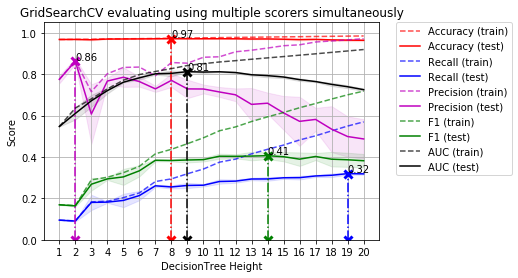

In [160]:
%%time
# Decision Tree
model_type = 'Decision Tree'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics)

In [207]:
save_load_model(1, 'dtree.pkl', grid_search_output, optimal_model)

In [206]:
#grid_search_output
grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy', 'rank_test_Accuracy']]

,params,mean_test_AUC,rank_test_AUC,mean_test_Recall,rank_test_Recall,mean_test_Precision,mean_test_Accuracy,rank_test_Accuracy
0,{'max_depth': 1},0.546973,20,0.094952,19,0.774602,0.967362,15
1,{'max_depth': 2},0.610104,19,0.090548,20,0.862068,0.967670,14
2,{'max_depth': 3},0.671387,18,0.180516,18,0.607144,0.965948,17
3,{'max_depth': 4},0.720328,17,0.181968,17,0.766603,0.969436,11
4,{'max_depth': 5},0.761040,13,0.190098,16,0.785065,0.969736,9
5,{'max_depth': 6},0.782093,10,0.213666,15,0.764053,0.970160,7
6,{'max_depth': 7},0.801577,6,0.260756,13,0.728785,0.970730,4
7,{'max_depth': 8},0.803800,5,0.255191,14,0.769901,0.971236,1
8,{'max_depth': 9},0.812002,1,0.262499,12,0.728680,0.970710,5
9,{'max_depth': 10},0.809982,3,0.263611,11,0.728188,0.970786,3


In [213]:
optimal_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [214]:
print(optimal_model.predict_proba(X))
df_predictions = generate_predictions(df_test, model_features, optimal_model, './data/results/approach1/predictions_dtree.csv')

[[0.96690165 0.03309835]
 [0.98631072 0.01368928]
 [0.98631072 0.01368928]
 ...
 [0.99600682 0.00399318]
 [0.89251677 0.10748323]
 [0.99101622 0.00898378]]


In [167]:
Xt = df_test[model_features]
Xt.head()

,x0_C,x0_H,x0_R,x0_S,x0_W,C1,C13,C5,C9,D1,D10,D11,D15,D3,D5,TransactionAmt,V10,V100,V101,V102,V104,V105,V108,V109,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V129,V13,V130,V131,V135,V136,V137,V15,V17,V19,V2,V20,V23,V24,V26,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V297,V3,V300,V301,V302,V303,V309,V31,V310,V312,V313,V314,V315,V319,V320,V321,V35,V36,V37,V38,V39,V4,V40,V42,V44,V45,V46,V47,V48,V5,V51,V53,V54,V55,V56,V59,V61,V62,V64,V66,V67,V69,V7,V73,V75,V76,V77,V78,V79,V80,V82,V83,V85,V86,V87,V9,V90,V98,dist1
0,0.0,0.0,0.0,0.0,1.0,6.0,115.0,3.0,6.0,419.0,418.0,203.0,409.0,27.0,27.0,31.95,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000000,0.0,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,47.950001,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,3.0,12.0,0.0,2.0,149.0,231.0,634.0,634.0,7.0,7.0,49.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,280.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,1.0,2.0,22.0,0.0,4.0,137.0,136.0,136.0,97.0,10.0,10.0,171.00,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,705.000000,0.000000,0.0,263.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,1058.000000,0.000000,0.000000,0.000000,0.000000,0.0,263.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,2635.0
3,0.0,0.0,0.0,0.0,1.0,5.0,7.0,1.0,2.0,42.0,242.0,242.0,242.0,41.0,41.0,284.95,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,17.0
4,0.0,0.0,0.0,0.0,1.0,6.0,14.0,2.0,5.0,22.0,22.0,22.0,22.0,0.0,0.0,67.95,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,67.949997,1.0,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,67.949997,0.0,183.850006,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0


### Logistic Regression

In [215]:
%%time
# Logistic Regression
model_type = 'Logistic Regression'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics)

Performing grid search to determine the optimal parameters ...
CPU times: user 7min 41s, sys: 2.92 s, total: 7min 44s
Wall time: 42min 38s


In [220]:
save_load_model(1, 'logistic.pkl', grid_search_output, optimal_model)

In [217]:
optimal_model

LogisticRegression(C=0.3, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [221]:
grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy', 'rank_test_Accuracy']]

,params,mean_test_AUC,rank_test_AUC,mean_test_Recall,rank_test_Recall,mean_test_Precision,mean_test_Accuracy,rank_test_Accuracy
0,{'C': 0.001},0.792093,4,0.695834,6,0.094170,0.753969,6
1,{'C': 0.003},0.789527,8,0.702947,4,0.086313,0.714963,12
2,{'C': 0.005},0.792123,3,0.695785,7,0.094460,0.754743,5
3,{'C': 0.01},0.784519,11,0.707690,2,0.085046,0.717921,11
4,{'C': 0.03},0.783696,13,0.704641,3,0.088341,0.730902,10
5,{'C': 0.05},0.784210,12,0.711852,1,0.081540,0.699316,13
6,{'C': 0.1},0.791292,5,0.692494,10,0.095408,0.756680,4
7,{'C': 0.3},0.793199,1,0.684848,13,0.096567,0.762927,1
8,{'C': 0.5},0.788710,9,0.700770,5,0.088806,0.733105,9
9,{'C': 1},0.792772,2,0.693123,9,0.094877,0.756782,3


In [219]:
print(optimal_model.predict_proba(X))
df_predictions = generate_predictions(df_test, model_features, optimal_model, './data/results/approach1/predictions_logistic.csv')

[[0.58169197 0.41830803]
 [0.6440285  0.3559715 ]
 [0.64152879 0.35847121]
 ...
 [0.79677663 0.20322337]
 [0.28143006 0.71856994]
 [0.54165549 0.45834451]]


### RandomForest

In [222]:
%%time
# Random Forest
model_type = 'Random Forest'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics)

Performing grid search to determine the optimal parameters ...
CPU times: user 40.9 s, sys: 1.1 s, total: 42 s
Wall time: 6min 12s


In [226]:
save_load_model(1, 'rf.pkl', grid_search_output, optimal_model)

In [223]:
optimal_model

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=9, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [224]:
grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy', 'rank_test_Accuracy']]

,params,mean_test_AUC,rank_test_AUC,mean_test_Recall,rank_test_Recall,mean_test_Precision,mean_test_Accuracy,rank_test_Accuracy
0,"{'max_depth': 1, 'n_estimators': 1}",0.665799,100,0.566810,99,0.086802,0.757861,30
1,"{'max_depth': 1, 'n_estimators': 2}",0.698125,99,0.568358,98,0.086383,0.753790,32
2,"{'max_depth': 1, 'n_estimators': 3}",0.703356,98,0.582636,97,0.085018,0.749087,35
3,"{'max_depth': 1, 'n_estimators': 4}",0.704279,97,0.582733,96,0.084809,0.747716,36
4,"{'max_depth': 1, 'n_estimators': 5}",0.705631,96,0.696361,60,0.067820,0.621130,97
5,"{'max_depth': 1, 'n_estimators': 6}",0.708714,94,0.587621,95,0.084971,0.746654,37
6,"{'max_depth': 1, 'n_estimators': 7}",0.708765,93,0.698975,57,0.067602,0.618746,98
7,"{'max_depth': 1, 'n_estimators': 8}",0.708489,95,0.588976,94,0.083083,0.740566,41
8,"{'max_depth': 1, 'n_estimators': 9}",0.721416,90,0.699846,55,0.066781,0.616363,99
9,"{'max_depth': 1, 'n_estimators': 10}",0.721352,91,0.792774,1,0.053543,0.499704,100


In [225]:
print(optimal_model.predict_proba(X))
df_predictions = generate_predictions(df_test, model_features, optimal_model, './data/results/approach1/predictions_rf.csv')

[[0.6341826  0.3658174 ]
 [0.71508937 0.28491063]
 [0.73548287 0.26451713]
 ...
 [0.89537242 0.10462758]
 [0.22385704 0.77614296]
 [0.85746021 0.14253979]]


In [229]:
len(optimal_model.feature_importances_)

120

In [249]:
df_feature_importance = pd.concat([pd.Series(X.columns).rename('features'), pd.Series(optimal_model.feature_importances_).rename('importance')], axis=1).sort_values('importance', ascending=False).reset_index(drop=True)
df_feature_importance['normalized_importance'] = df_feature_importance['importance'] / df_feature_importance['importance'].sum()
df_feature_importance['cumulative_importance'] = np.cumsum(df_feature_importance['normalized_importance'])

In [257]:
df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]

,features,importance,normalized_importance,cumulative_importance
0,V69,0.091344,0.091344,0.091344
1,V73,0.077898,0.077898,0.169243
2,D3,0.069526,0.069526,0.238769
3,C1,0.061965,0.061965,0.300734
4,V90,0.041202,0.041202,0.341936
5,C13,0.036959,0.036959,0.378895
6,V79,0.035653,0.035653,0.414548
7,C5,0.034008,0.034008,0.448556
8,V31,0.032199,0.032199,0.480754
9,V59,0.030904,0.030904,0.511658


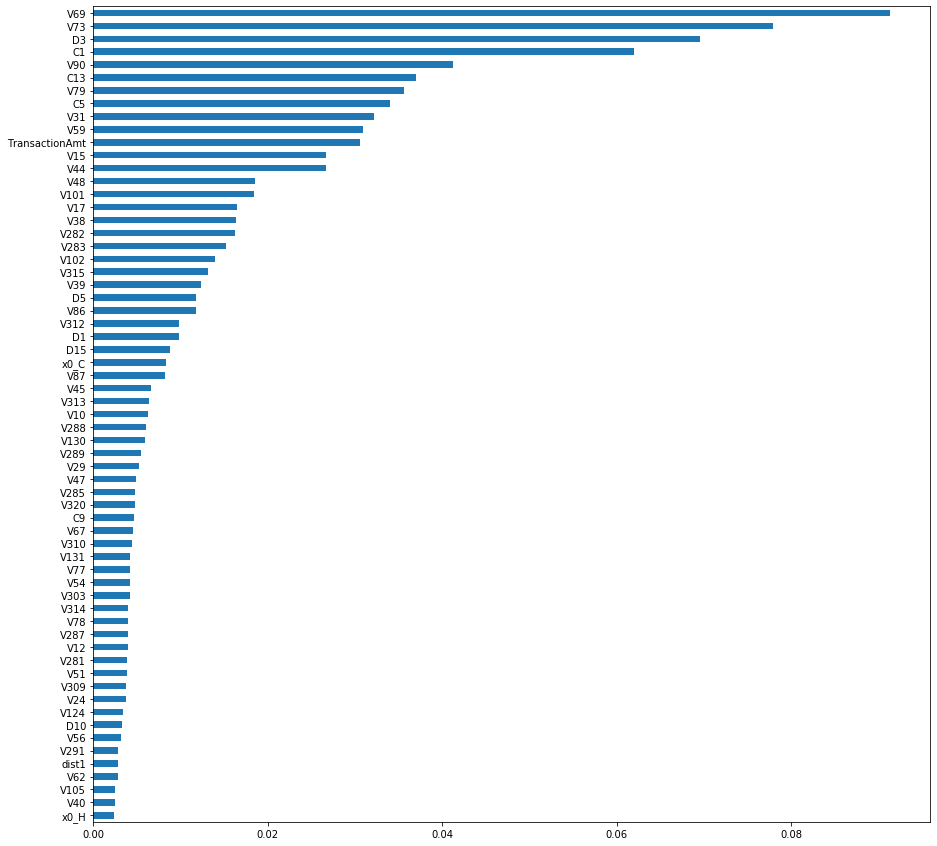

In [261]:
df_select = df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]
fig = plt.figure(figsize=(15, 15))
ax = df_select['importance'][::-1].plot(kind='barh')
plt.yticks(range(len(df_select))[::-1], df_select['features'])
plt.show()

### LightGBM

In [269]:
%%time
# LightGBM
model_type = 'LightGBM'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics)

Performing grid search to determine the optimal parameters ...
CPU times: user 51.8 s, sys: 7.02 s, total: 58.8 s
Wall time: 9min 1s


In [270]:
save_load_model(1, 'lgbm.pkl', grid_search_output, optimal_model)

In [271]:
optimal_model

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=10, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=10, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=0, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [273]:
grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy']]

,params,mean_test_AUC,rank_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_Accuracy
0,"{'max_depth': 5, 'n_estimators': 5}",0.847017,36,0.708174,0.134459,0.829923
1,"{'max_depth': 5, 'n_estimators': 6}",0.848331,35,0.706722,0.134113,0.829468
2,"{'max_depth': 5, 'n_estimators': 7}",0.850606,33,0.709916,0.135887,0.831564
3,"{'max_depth': 5, 'n_estimators': 8}",0.851584,30,0.710448,0.136888,0.832850
4,"{'max_depth': 5, 'n_estimators': 9}",0.853084,25,0.711271,0.136206,0.831945
5,"{'max_depth': 5, 'n_estimators': 10}",0.854146,22,0.708706,0.139484,0.836785
6,"{'max_depth': 6, 'n_estimators': 5}",0.849601,34,0.715820,0.134746,0.828911
7,"{'max_depth': 6, 'n_estimators': 6}",0.852845,27,0.716400,0.137421,0.832355
8,"{'max_depth': 6, 'n_estimators': 7}",0.854963,18,0.716401,0.138740,0.834174
9,"{'max_depth': 6, 'n_estimators': 8}",0.855623,14,0.715481,0.139642,0.835483


In [274]:
print(optimal_model.predict_proba(X))
df_predictions = generate_predictions(df_test, model_features, optimal_model, './data/results/approach1/predictions_lgbm.csv')

[[0.50383469 0.49616531]
 [0.69534189 0.30465811]
 [0.69286625 0.30713375]
 ...
 [0.75697107 0.24302893]
 [0.28873727 0.71126273]
 [0.70258096 0.29741904]]


In [276]:
df_feature_importance = pd.concat([pd.Series(X.columns).rename('features'), pd.Series(optimal_model.feature_importances_).rename('importance')], axis=1).sort_values('importance', ascending=False).reset_index(drop=True)
df_feature_importance['normalized_importance'] = df_feature_importance['importance'] / df_feature_importance['importance'].sum()
df_feature_importance['cumulative_importance'] = np.cumsum(df_feature_importance['normalized_importance'])

In [277]:
df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]

,features,importance,normalized_importance,cumulative_importance
0,C13,37,0.123333,0.123333
1,TransactionAmt,34,0.113333,0.236667
2,C1,28,0.093333,0.330000
3,V102,20,0.066667,0.396667
4,D15,17,0.056667,0.453333
5,x0_C,15,0.050000,0.503333
6,V283,13,0.043333,0.546667
7,V312,9,0.030000,0.576667
8,D3,9,0.030000,0.606667
9,V285,6,0.020000,0.626667


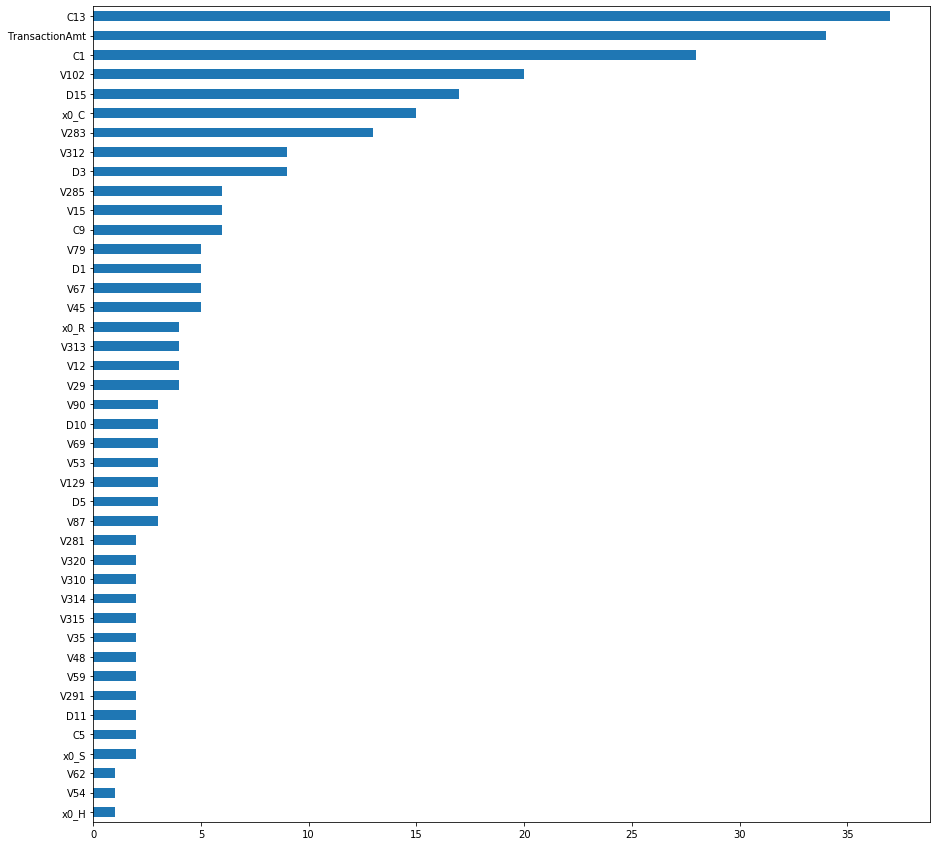

In [278]:
df_select = df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]
fig = plt.figure(figsize=(15, 15))
ax = df_select['importance'][::-1].plot(kind='barh')
plt.yticks(range(len(df_select))[::-1], df_select['features'])
plt.show()

### XGBoost

In [282]:
%%time
# XGBoost
model_type = 'XGBoost'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics)

Performing grid search to determine the optimal parameters ...
CPU times: user 5min 4s, sys: 4.8 s, total: 5min 9s
Wall time: 1h 13min 26s


In [283]:
save_load_model(1, 'xgb.pkl', grid_search_output, optimal_model)

In [284]:
optimal_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [285]:
grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy']]

,params,mean_test_AUC,rank_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_Accuracy
0,"{'max_depth': 5, 'n_estimators': 5}",0.800521,96,0.203552,0.789063,0.970188
1,"{'max_depth': 5, 'n_estimators': 6}",0.803485,95,0.200648,0.793781,0.970180
2,"{'max_depth': 5, 'n_estimators': 7}",0.806607,94,0.199777,0.792475,0.970143
3,"{'max_depth': 5, 'n_estimators': 8}",0.808258,93,0.201325,0.786638,0.970124
4,"{'max_depth': 5, 'n_estimators': 9}",0.814285,92,0.203358,0.790987,0.970219
5,"{'max_depth': 5, 'n_estimators': 10}",0.817156,90,0.201761,0.806650,0.970361
6,"{'max_depth': 5, 'n_estimators': 11}",0.824968,87,0.206020,0.811330,0.970529
7,"{'max_depth': 5, 'n_estimators': 12}",0.826371,85,0.208052,0.805788,0.970507
8,"{'max_depth': 5, 'n_estimators': 13}",0.833411,83,0.213521,0.818221,0.970808
9,"{'max_depth': 5, 'n_estimators': 14}",0.835267,80,0.217780,0.817635,0.970916


In [286]:
print(optimal_model.predict_proba(X))
df_predictions = generate_predictions(df_test, model_features, optimal_model, './data/results/approach1/predictions_xgb.csv')

[[0.90545374 0.09454628]
 [0.9257358  0.07426421]
 [0.9257358  0.07426421]
 ...
 [0.9313318  0.06866819]
 [0.79545164 0.20454834]
 [0.92635524 0.07364474]]


In [287]:
df_feature_importance = pd.concat([pd.Series(X.columns).rename('features'), pd.Series(optimal_model.feature_importances_).rename('importance')], axis=1).sort_values('importance', ascending=False).reset_index(drop=True)
df_feature_importance['normalized_importance'] = df_feature_importance['importance'] / df_feature_importance['importance'].sum()
df_feature_importance['cumulative_importance'] = np.cumsum(df_feature_importance['normalized_importance'])

In [288]:
df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]

,features,importance,normalized_importance,cumulative_importance
0,V45,0.106706,0.106706,0.106706
1,x0_C,0.061872,0.061872,0.168578
2,V90,0.057741,0.057741,0.226319
3,C13,0.033273,0.033273,0.259592
4,V283,0.031884,0.031884,0.291476
5,V15,0.027257,0.027257,0.318733
6,x0_W,0.025798,0.025798,0.344531
7,V111,0.025300,0.025300,0.369832
8,C1,0.025145,0.025145,0.394976
9,V40,0.022135,0.022135,0.417111


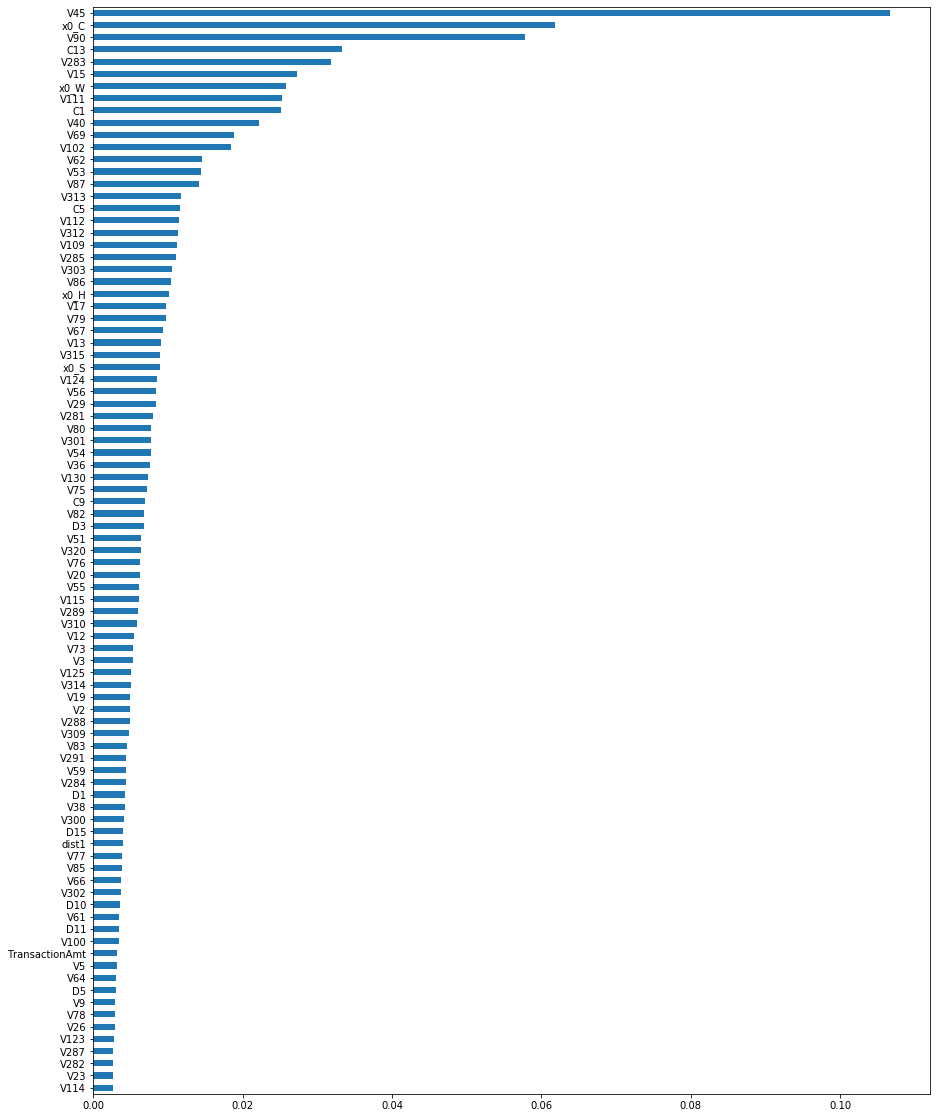

In [290]:
df_select = df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]
fig = plt.figure(figsize=(15, 20))
ax = df_select['importance'][::-1].plot(kind='barh')
plt.yticks(range(len(df_select))[::-1], df_select['features'])
plt.show()